Code inspiration - [Andrej Karpathy's nanoGPT](https://github.com/karpathy/nanoGPT)

In [1]:
!ls

sample_data


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  with open(fn, 'wb') as f:
    f.write(uploaded[fn])
  print('File uploaded successfully!')


Saving biden.txt to biden.txt
User uploaded file "biden.txt" with length 269315 bytes
File uploaded successfully!


<IPython.core.display.HTML object>

Upload widget is only available when the cell has been executed in the
 current browser session. Please rerun this cell to enable.

In [3]:
!ls

biden.txt  sample_data


In [4]:
pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00


In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4o")
assert enc.decode(enc.encode("hello world")) == "hello world"

In [6]:
enc.encode('hello world')

[24912, 2375]

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
# hyperparameters
batch_size = 16
block_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
torch.cuda.is_available()

True

In [ ]:
with open('biden.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [11]:
tokens = list(set(enc.encode(text)))
vocab_size = len(tokens)
print(vocab_size)

6114


In [ ]:
encode = enc.encode
decode = enc.decode

In [ ]:
tknid2idx = {}
i = 0
for t in tokens:
  if t not in tknid2idx:
    tknid2idx[t] = i
    i += 1

idx2tknid = {i : t for t, i in tknid2idx.items()}

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:]
val_data = data[n:]

In [ ]:
# data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [ ]:
# loss estimation
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(torch.tensor([[tknid2idx[i] for i in row]
                                    for row in X.tolist()]).to(device), \
                                 torch.tensor([[tknid2idx[i] for i in row]
                                    for row in Y.tolist()]).to(device))
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

In [18]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) #.to(device))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        pos_emb = pos_emb.unsqueeze(0).expand(B, -1, -1)  # (B,T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            tknidx = torch.tensor([[idx2tknid[i] for i in row] for row in idx.tolist()])
        return tknidx

model = GPTLanguageModel().to(device)
xb, yb = get_batch('train')
logits, loss = model(torch.tensor([[tknid2idx[i] for i in row]
                               for row in xb.tolist()]).to(device), \
                     torch.tensor([[tknid2idx[i] for i in row]
                               for row in yb.tolist()]).to(device))
print(logits.shape)
print(loss)

torch.Size([2048, 6114])
tensor(8.8032, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [ ]:
# create a PyTorch optimizer
learning_rate = 2e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
iterations = []
itr = 0

In [ ]:
max_iters = 3_000
eval_iters = 200
eval_interval = 100

<Figure size 1200x400 with 1 Axes>

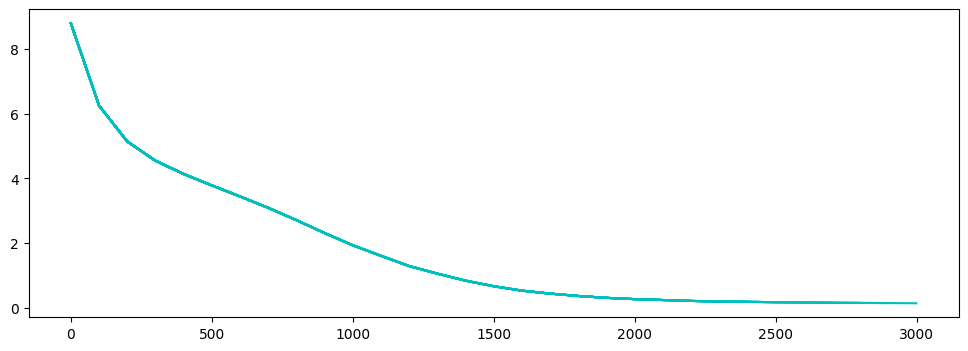

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        try:
            losses = estimate_loss()
        except Exception as e:
            print(f"Error in estimate_loss(): {e}")
            import traceback
            traceback.print_exc()
        train_losses.append(losses['train'])
        iterations.append(itr)

        clear_output(wait=True)
        ax.plot(iterations, train_losses, 'c-')
        plt.pause(0.001)
        display(fig)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(torch.tensor([[tknid2idx[i] for i in row]
                               for row in xb.tolist()]).to(device), \
                         torch.tensor([[tknid2idx[i] for i in row]
                               for row in yb.tolist()]).to(device))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    itr += 1

In [24]:
prompt = 'All'
out = encode(prompt)
print(decode(model.generate(idx = torch.tensor(out, dtype=torch.long).view(1, -1).to(device), max_new_tokens=500)[0].tolist()))

 norms for its city of objects we owe the destruction. They done for suck and ripping us off.

This is to technologies.

For every day, they point of those who work with rhetorical flourish, and they want to make sure that they need to continue to serve their country — and so much more than in fact —.

And folks are not made after 400,000 their communities in the list of recent years.

A single day when we can do it together.

This is a significant laws ever philosopher Kierkegaard: “[F]a transparency, each and minority. That’s a President, and gets sick.

When I cautioned the government rebuilding of Israel wrong, and natural to fulfill unacceptable.

The private jets, which I was a pandemic only six months before him a major who had gotten in such woman a long time to fund — let me. And they stand just two- — I would go on a major who just rewards go to a minimum later, and they even pay for millions of four years as well to pay your families before the price for their aggression hav

In [ ]:
torch.save(model.state_dict(), 'biden_GPT.pth')
# m.load_state_dict(torch.load('biden_GPT.pth'))